# Neural Style Transfer

In [2]:
# Packages
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
import IPython.display as display

np.random.seed(7)
%matplotlib inline

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

### 1) Load the Content and style image

In [4]:
content_path = 'content.jpg'
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

### 2) Utils

In [5]:
def load_image(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [6]:
def show(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

### 3) Visualizing Data

In [7]:
content = load_image(content_path)
style = load_image(style_path)

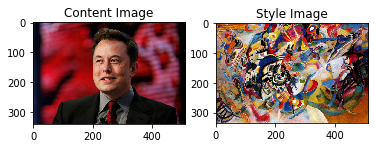

In [8]:
plt.subplot(1, 2, 1)
show(content, 'Content Image')

plt.subplot(1, 2, 2)
show(style, 'Style Image')

In [9]:
content.shape

TensorShape([1, 341, 512, 3])

In [10]:
style.shape

TensorShape([1, 336, 512, 3])

### 4) Instantiate the vgg19 model

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
# Content layer
content_layers = ['block5_conv2']

# Style layer
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### 6) custom vgg model

In [13]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [14]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style*255)
#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5255
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8877
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.234
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2522
  mean:  59.179485



### 7) Defining Gram matrix

In [15]:
def gram_matrix(tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
  input_shape = tf.shape(tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

### 8) Custom style model

In [16]:
class CustomStyleModel(tf.keras.models.Model):
    """ It returns the content and style features 
        from respective images"""
    def __init__(self, style_layers, content_layers):
        super(CustomStyleModel, self).__init__()
        self.vgg = vgg_layers(style_layers+content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        # Scale back the pixel value
        inputs = inputs * 255.0
        # preprocess them with respect to vgg19 stats
        preprocessed_input = preprocess_input(inputs)
        # Pass through mini network
        outputs = self.vgg(preprocessed_input)
        # Segregate the style and content representations
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        # Gram matrix for each layer
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        # store in dict
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}

In [19]:
extractor = CustomStyleModel(style_layers, content_layers)
results = extractor(tf.constant(content))
style_results = results['style']

In [20]:

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0005506139
    max:  34416.914
    mean:  733.40607

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  80789.28
    mean:  13204.838

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  339384.12
    mean:  12822.014

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5442657.5
    mean:  220291.14

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  304664.72
    mean:  1991.1276

Contents:
   block5_conv2
    shape:  (1, 21, 32, 512)
    min:  0.0
    max:  1894.2644
    mean:  16.597929


### 9) Running gradient descent

In [21]:
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']


Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [22]:
image = tf.Variable(content)

In [23]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [24]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [25]:
style_weight=1e-2
content_weight=1e4

In [26]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [27]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

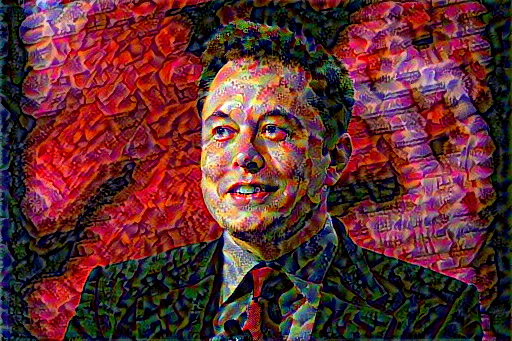

Train step: 5
Total time: 15.1


In [31]:
start = time.time()
epochs = 5
steps_per_epoch = 1

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(f'Epochs {step} / {steps_per_epoch}')
        print("=>", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
    

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

#### a) Custom function

In [43]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

In [44]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [45]:
total_variation_loss(image).numpy()

79357.85

#### b) Tensorflow built in function for variation loss

In [46]:
tf.image.total_variation(image).numpy()

array([79357.85], dtype=float32)

### Optimization

In [47]:
total_variation_weight=30

In [48]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [49]:
image = tf.Variable(content)

In [50]:
def edit(image):
    import time
    start = time.time()

    epochs = 5
    steps_per_epoch = 1

    step = 0
    for n in range(epochs):
      for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
      display.clear_output(wait=True)
      display.display(tensor_to_image(image))
      print("Train step: {}".format(step))

    end = time.time()
    print("Total time: {:.1f}".format(end-start))

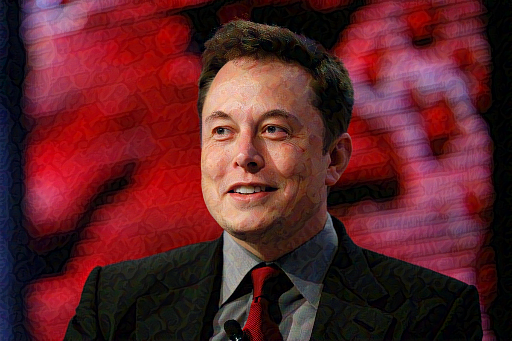

Train step: 4


In [ ]:
edit(image)

### Saving The image

In [40]:
def save(filename, image):
    image = tensor_to_image(image)
    image.save(filename)
    print("Saved!")

In [42]:
save('styled_image.jpg', image)

Saved!
